In [15]:
# NB14 — Deploy Pipeline (daily inference + monitoring + logging)

from pathlib import Path
import json, math, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone

# Paths
DATA = Path("data"); ART = Path("artifacts"); FIG = Path("reports/figures"); LOG = Path("logs")
for p in (DATA, ART, FIG, LOG): p.mkdir(parents=True, exist_ok=True)

# Defaults (will be overridden by artifacts where possible)
TAU_DEFAULT = 0.59          # threshold
FEE_BPS_DEFAULT = 5.0       # one-way fees (bps)
SLIPPAGE_BPS_DEFAULT = 0.0  # one-way slippage (bps)
LOOKBACK_REALIZED = 60      # monitoring window (days)
SEED = 42

print("NB14 pipeline config loaded.")


NB14 pipeline config loaded.


In [16]:
from joblib import load

def load_threshold():
    # prefer artifacts/threshold.json; fallback to backtest_summary.json
    tau = TAU_DEFAULT
    thrp = ART/"threshold.json"
    if thrp.exists():
        t = json.loads(thrp.read_text(encoding="utf-8"))
        if isinstance(t, dict):
            if "threshold" in t: tau = float(t["threshold"])
            elif "LR" in t and isinstance(t["LR"], dict) and "tau" in t["LR"]: tau = float(t["LR"]["tau"])
            elif "tau" in t: tau = float(t["tau"])
    else:
        bts = ART/"backtest_summary.json"
        if bts.exists():
            s = json.loads(bts.read_text(encoding="utf-8"))
            try:
                tau = float(s["models"]["LR"]["tau"])
            except Exception:
                pass
    return tau

def load_costs():
    fee, slip = FEE_BPS_DEFAULT, SLIPPAGE_BPS_DEFAULT
    bts = ART/"backtest_summary.json"
    if bts.exists():
        s = json.loads(bts.read_text(encoding="utf-8"))
        fee = float(s.get("fee_bps", fee))
        slip = float(s.get("slippage_bps", slip))
    return fee, slip

def load_df():
    # Use storage_format if present
    fmt_path = DATA/"storage_format.json"
    fmt = "csv"
    if fmt_path.exists():
        try:
            raw = json.loads(fmt_path.read_text(encoding="utf-8"))
            recs = raw if isinstance(raw, list) else [raw]
            if recs and isinstance(recs[-1], dict):
                fmt = recs[-1].get("format", "csv").lower()
        except Exception:
            pass
    if fmt == "parquet" and (DATA/"df_nb02.parquet").exists():
        df = pd.read_parquet(DATA/"df_nb02.parquet")
    else:
        df = pd.read_csv(DATA/"df_nb02.csv", parse_dates=["date"])
    df = df.sort_values("date").reset_index(drop=True)
    # ensure label/ret_next
    if "ret_next" not in df.columns:
        if "ret1" in df.columns:
            df["ret_next"] = df["ret1"].shift(-1)
        elif "close" in df.columns:
            df["ret_next"] = pd.Series(df["close"]).pct_change().shift(-1)
        else:
            raise KeyError("No 'ret_next' or 'close' to derive next-day return.")
    return df

def load_model_and_features():
    feat_cols = json.loads((ART/"feature_list.json").read_text(encoding="utf-8"))
    lr = load(ART/"lr.joblib")
    scaler = load(ART/"scaler.joblib") if (ART/"scaler.joblib").exists() else None
    return lr, scaler, feat_cols

TAU = load_threshold()
FEE_BPS, SLIP_BPS = load_costs()
FEE = (FEE_BPS + SLIP_BPS) / 10000.0

df = load_df()
lr, scaler, feat_cols = load_model_and_features()

# Ensure all features exist
for c in feat_cols:
    if c not in df.columns:
        df[c] = 0.0

print(f"Daily inference config → τ={TAU:.3f} | fee={FEE_BPS:.1f} bps | slippage={SLIP_BPS:.1f} bps")
print(f"Rows: {len(df)}  |  Span: {df['date'].min().date()} → {df['date'].max().date()}")


Daily inference config → τ=0.590 | fee=5.0 bps | slippage=0.0 bps
Rows: 2686  |  Span: 2015-02-06 → 2025-10-10


In [17]:
# Read existing signals (if present) to be incremental
sig_p = DATA/"signals.csv"
signals_prev = pd.read_csv(sig_p, parse_dates=["date"]) if sig_p.exists() else None
last_dt = signals_prev["date"].max() if signals_prev is not None and len(signals_prev) else None

# Select slice to process
if last_dt is None:
    df_new = df.copy()
else:
    df_new = df[df["date"] > last_dt].copy()

# Nothing new? We'll still print status and exit later
print("New rows to process:", len(df_new))

# Build model inputs
X = df_new[feat_cols].to_numpy() if len(df_new) else np.empty((0, len(feat_cols)))
if len(df_new) and scaler is not None:
    X = scaler.transform(X)
p = lr.predict_proba(X)[:,1] if len(df_new) else np.array([])

# Assemble slice DataFrame
slice_df = pd.DataFrame({
    "date": df_new["date"].to_numpy(),
    "close": df_new["close"].to_numpy() if "close" in df_new else np.nan,
    "prob": p,
})
slice_df["signal"] = (slice_df["prob"] >= TAU).astype(int)
# align realized ret_next
slice_df["ret_next"] = df_new["ret_next"].to_numpy() if "ret_next" in df_new else np.nan


New rows to process: 0


In [18]:
# Determine previous signal for the first new row
def compute_slice_equity(sdf, prev_signal=0, prev_equity=1.0, fee=FEE):
    if len(sdf) == 0:
        sdf["signal_prev"] = []
        sdf["flip"] = []
        sdf["strategy_ret"] = []
        sdf["equity"] = []
        return sdf

    sig = sdf["signal"].to_numpy().astype(int)
    sig_prev = np.r_[prev_signal, sig[:-1]]
    flips = (sig != sig_prev).astype(int)
    # trading return: long when signal==1, pay fee on flips
    r = (sig * sdf["ret_next"].to_numpy()) - (flips * fee)
    r = np.nan_to_num(r, nan=0.0)
    eq = (1 + pd.Series(r)).cumprod() * float(prev_equity)

    sdf = sdf.copy()
    sdf["signal_prev"] = sig_prev
    sdf["flip"] = flips
    sdf["strategy_ret"] = r
    sdf["equity"] = eq.values
    return sdf

prev_sig = int(signals_prev["signal"].iloc[-1]) if (signals_prev is not None and len(signals_prev)) else 0
prev_eq  = float(signals_prev["equity"].iloc[-1]) if (signals_prev is not None and len(signals_prev)) else 1.0

slice_df = compute_slice_equity(slice_df, prev_signal=prev_sig, prev_equity=prev_eq, fee=FEE)
slice_df.head(3)


,date,close,prob,signal,ret_next,signal_prev,flip,strategy_ret,equity


In [19]:
# Merge with existing signals and recompute a consistent equity column end-to-end
if signals_prev is None or len(signals_prev)==0:
    signals = slice_df.copy()
else:
    signals = pd.concat([signals_prev, slice_df], ignore_index=True)

# Recompute equity across the entire file to avoid drift from numerical accumulation
sig = signals["signal"].to_numpy().astype(int)
sig_prev = np.r_[0, sig[:-1]]
flips = (sig != sig_prev).astype(int)
r = (sig * signals["ret_next"].fillna(0.0).to_numpy()) - (flips * FEE)
signals["signal_prev"] = sig_prev
signals["flip"] = flips
signals["strategy_ret"] = r
signals["equity"] = (1 + pd.Series(r)).cumprod()

signals.to_csv(sig_p, index=False)
print("Saved:", sig_p)

# Paper-trade snapshot
snap = {
    "tau": TAU,
    "fee_bps": FEE_BPS,
    "slippage_bps": SLIP_BPS,
    "as_of": str(df["date"].max().date()),
    "rows": int(len(signals)),
    "equity": float(signals["equity"].iloc[-1]),
    "turnover": float(np.mean(np.abs(np.diff(sig)))) if len(sig)>1 else 0.0
}
(ART/"paper_trade.json").write_text(json.dumps(snap, indent=2), encoding="utf-8")
print("Wrote:", ART/"paper_trade.json")
display(pd.DataFrame([snap]))


Saved: data\signals.csv
Wrote: artifacts\paper_trade.json


,tau,fee_bps,slippage_bps,as_of,rows,equity,turnover
0,0.59,5.0,0.0,2025-10-10,2686,1.217782,0.153445


In [20]:
from sklearn.metrics import roc_auc_score, brier_score_loss

def kpis(r, freq=252):
    r = pd.Series(np.nan_to_num(r, nan=0.0))
    eq = (1+r).cumprod()
    cagr = (1 + r).prod() ** (freq / max(len(r),1)) - 1
    vol  = r.std() * np.sqrt(freq)
    sharpe = (cagr / vol) if vol > 0 else None
    mdd = float((eq/eq.cummax() - 1).min())
    return dict(CAGR=float(cagr), Vol=float(vol), Sharpe=(None if sharpe is None else float(sharpe)), MaxDD=mdd)

# realized window = rows where ret_next not NaN
real = signals.dropna(subset=["ret_next"]).copy()
win = real.tail(LOOKBACK_REALIZED).copy()

# classification metrics on realized window
try:
    auc60 = float(roc_auc_score(win["signal"], win["prob"])) if win["signal"].nunique() > 1 else np.nan
except Exception:  # fall back to y if present (rare in signals)
    auc60 = np.nan
try:
    brier60 = float(brier_score_loss(win["signal"], win["prob"]))
except Exception:
    brier60 = np.nan

# trading KPIs on last 60d
r60 = (win["signal"].to_numpy().astype(int) * win["ret_next"].to_numpy()) - (np.abs(np.diff(np.r_[0, win["signal"].to_numpy().astype(int)])) * FEE)
k60 = kpis(r60)
coverage60 = float(win["signal"].mean())
turnover60 = float(np.mean(np.abs(np.diff(np.r_[0, win["signal"].to_numpy().astype(int)]))))

# status rules (tweak thresholds as you like)
issues = []
if (k60["Sharpe"] is None) or (k60["Sharpe"] < -0.5): issues.append("Sharpe60<-0.5")
if not math.isnan(auc60) and auc60 < 0.52: issues.append("AUC60<0.52")
if not math.isnan(brier60) and brier60 > 0.27: issues.append("Brier60>0.27")
status = "OK" if len(issues)==0 else "ALERT"

monitor = {
    "as_of": str(df["date"].max().date()),
    "lookback_days": LOOKBACK_REALIZED,
    "status": status,
    "issues": issues,
    "kpis60": k60,
    "cls60": {"AUC": auc60, "Brier": brier60, "days": int(len(win))},
}
(ART/"monitor_snapshot.json").write_text(json.dumps(monitor, indent=2), encoding="utf-8")
print("Wrote:", ART/"monitor_snapshot.json")
display(pd.DataFrame([monitor]))


Wrote: artifacts\monitor_snapshot.json


,as_of,lookback_days,status,issues,kpis60,cls60
0,2025-10-10,60,ALERT,[Sharpe60<-0.5],"{'CAGR': -0.1804741756863275, 'Vol': 0.0633295...","{'AUC': 1.0, 'Brier': 0.25698282615295426, 'da..."


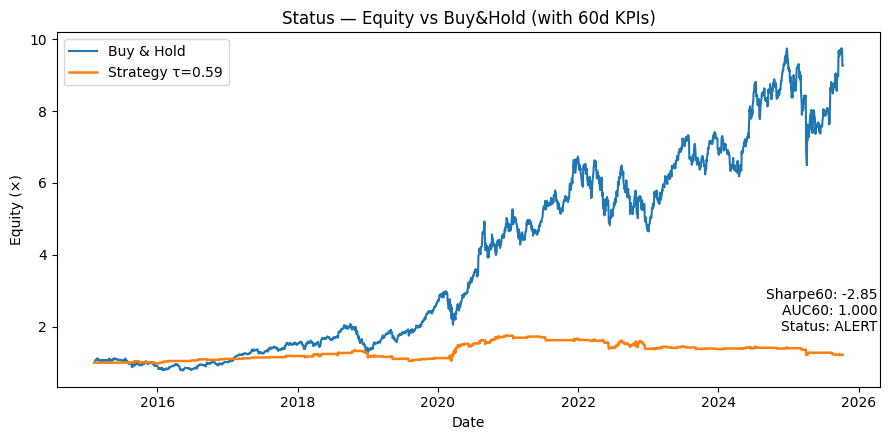

Saved: reports\figures\status_nb14.png


In [21]:
# --- Plot static status chart (robust formatting) ---
import json, math
from pathlib import Path
import matplotlib.pyplot as plt

# Ensure figure directory exists
try:
    FIG_DIR
except NameError:
    FIG_DIR = Path("reports/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Reload snapshot
monitor = json.loads(Path("artifacts/monitor_snapshot.json").read_text(encoding="utf-8"))

def fmt_num(x, fmt):
    try:
        if x is None: return "NA"
        x = float(x)
        if math.isnan(x): return "NA"
        return format(x, fmt)
    except Exception:
        return "NA"

sharpe60 = fmt_num(monitor.get("kpis60", {}).get("Sharpe"), ".2f")
auc60    = fmt_num(monitor.get("cls60", {}).get("AUC"), ".3f")
status   = monitor.get("status", "NA")

plt.figure(figsize=(9, 4.5))
bh = (1 + signals["ret_next"].fillna(0.0)).cumprod()
plt.plot(signals["date"], bh, label="Buy & Hold")
plt.plot(signals["date"], signals["equity"], label=f"Strategy τ={TAU:.2f}", linewidth=1.8)

txt = f"Sharpe60: {sharpe60}\nAUC60: {auc60}\nStatus: {status}"
plt.title("Status — Equity vs Buy&Hold (with 60d KPIs)")
plt.xlabel("Date"); plt.ylabel("Equity (×)")
plt.legend()
plt.gcf().text(0.98, 0.35, txt, ha="right", va="top", fontsize=10)

plt.tight_layout()
out_path = FIG_DIR / "status_nb14.png"
plt.savefig(out_path, dpi=140)
plt.show()
print("Saved:", out_path)


In [22]:
rec = {
    "ts_utc": datetime.now(timezone.utc).isoformat(),
    "as_of": monitor["as_of"],
    "rows_total": int(len(signals)),
    "tau": TAU, "fee_bps": FEE_BPS, "slip_bps": SLIP_BPS,
    "status": monitor["status"], "issues": monitor["issues"],
    "equity": float(signals["equity"].iloc[-1]),
    "last_prob": float(signals["prob"].iloc[-1]),
    "last_signal": int(signals["signal"].iloc[-1]),
}
log_path = LOG/f"run_{monitor['as_of']}.jsonl"
with log_path.open("a", encoding="utf-8") as f:
    f.write(json.dumps(rec) + "\n")

print(f"RUN OK — processed up to {monitor['as_of']} | signals rows = {len(signals)}")
print("Log →", log_path)
print("Last signals row:"); display(signals.tail(1))


RUN OK — processed up to 2025-10-10 | signals rows = 2686
Log → logs\run_2025-10-10.jsonl
Last signals row:


,date,close,prob,signal,ret_next,signal_prev,flip,strategy_ret,equity
2685,2025-10-10,245.270004,0.565084,0,NaN,0,0,0.0,1.217782
